# Probability Calibration & Cost classification models

# Motivation

#### What is a calibrated classifier?

We can say that a well calibrated classifier is one that its probabilities corresponds to the real fraction of positives we observe in real life, meaning that we could interpret its probabilities as a confidence level as well. An example of a well calibrated (binary) classifier is one that if in 100 examples it predicts a probability of 0.7, then 70% of the examples will have class 1 and 30% will have a class 0.

#### Why care for calibration?

If we have a problem that we only care about the predictions of class 1 or 0, then we don't need to care for calibration, but if it is the case that the probabilities of the model will be used in our real life situation, then we would want that the probabilities really represents the likelihood of these events. 

Let's use an example of fraud detection, we can train a ML model to predict if a transaction is fraudulent or not (1/0). But for fraud detection, it is often the case that we need to analyze the costs involved in the prediction to determine if a fraud is likely fraudulent or not. A framework that can be used is the following: 

- Suppose we get a 10% comission over the amount transactioned if the transaction is complete, on the other hand, if the transacition was actually a fraud, then we would have to return to the customer 100% of the amount paid. In this case, a False Negative (FN) means that we would have a cost of `-total amount`, and a True Negative, a profit of `10% * total amount` 
- In this scenario, there are different costs associated with each prediction, so we could classify the examples based on the expected revenue for class 1, and the expected revenue for class 0. In the end, we can choose the prediction that has the highest expected revenue:

    $$\textnormal{expected revenue 1}  = (profitTP * prob1) + (costFP * prob0)$$
    $$\textnormal{expected revenue 0} = (profitTN * prob0) + (costFN * prob1)$$

- For each value in the confusion matrix, we can assign the following profit/cost structure: 
    - TP: 0 cost or profit because we classify the fraudulent transaction as fraud 
    - TN: 10% comission over the total amount 
    - FP: -10% comission, beacause we classify a fraud as one when it isn't 
    - FN: -total amount, real fraud that wasn't captured by the model -> we have to return the total amount to the customer 

    Let's use as an example a transaction of $50 that is not fraudulent and assume our model predicts a probability of 0.4 of being fraudulent, when the real probability was 0.1. Here is the impact of this difference:


In [13]:
#| echo: false
import pandas as pd 
pd.set_option('display.max_columns', None)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")

In [2]:
def get_example_value_dependent(prob_1, total_amount): 
    prob_0 = 1 - prob_1

    rev_tp = 0
    rev_fp = - (total_amount * 0.1)
    rev_tn = total_amount * 0.1
    rev_fn = -total_amount

    expected_rev_1 =  (rev_tp * prob_1) + (rev_fp * prob_0)
    expected_rev_0 =  (rev_tn * prob_0) + (rev_fn * prob_1)

    return expected_rev_1, expected_rev_0

def classify_sample(expected_rev_1, expected_rev_0): 
    if expected_rev_1 > expected_rev_0: return 1
    else: return 0

In [3]:
model_probability = 0.4
expected_rev_1, expected_rev_0 = get_example_value_dependent(model_probability, total_amount = 50)
print(f'Expected revenue class 1: {expected_rev_1}')
print(f'Expected revenue class 0: {expected_rev_0}')
print(f'Classification by model probability: {classify_sample(expected_rev_1, expected_rev_0)}\n')

real_probability = 0.1 
real_expected_rev_1, real_expected_rev_0 = get_example_value_dependent(real_probability, total_amount = 50)
print(f'Real expected revenue class 1: {real_expected_rev_1}')
print(f'Real expected revenue class 0: {real_expected_rev_0}')
print(f'Classification by model probability: {classify_sample(real_expected_rev_1, real_expected_rev_0)}')


Expected revenue class 1: -3.0
Expected revenue class 0: -17.0
Classification by model probability: 1

Real expected revenue class 1: -4.5
Real expected revenue class 0: -0.5
Classification by model probability: 0


#### Reasons for uncalibrated probabilities

- **Algorithms not trained using a probabilistic framework**

    There are only a few models that produce calibrated probabilities. That is because in order to give calibrated probabilities, the model must be trained in a probabilistic framework, such as maximum likelihood estimation. The main example that can return probabilities already calibrated is a Logistic Regression. ANNs can also have better calibration of probabilities than other models. 

    The opposite can occur for methods such as in Bagging Estimators. For a Random Forest to predict a probability = 0, it means that all estimators in the forest predict 0. In a Random Forest this is harder to occur because of the feature subsample used to build each tree, meaning that there is a relative high variance between the trees in the forest.    

- **Class imbalance** 

    When there is a case of high class imbalance, such as in fraud prevention problems, the model will naturally predict higher probabilities for the majority class. 


#### Dataset

For the rest of this post, we'll use the [Credit Card Fraud Detection](https://www.kaggle.com/code/sion1116/credit-card-fraud-detection/input) dataset available on Kaggle. Our goal will be to train a model to predict fraud and then use the same framework as before to classify each example as a fraud or not considering the expected profits and costs with each classification

In [4]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
df.Class.value_counts(normalize = False)

0    284315
1       492
Name: Class, dtype: int64

In [6]:
class_0 = df.query('Class == 0').sample(200_000)
class_1 = df.query('Class == 1')

fraud_data = pd.concat([class_0, class_1], axis = 0).reset_index(drop = True)

In [7]:
fraud_data.Class.value_counts(normalize = True)

0    0.997546
1    0.002454
Name: Class, dtype: float64

In [10]:
X = fraud_data.drop(['Class'], axis = 1)
y = fraud_data['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [11]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

In [14]:
model_preds = model.predict(X_test)

print(classification_report(y_test, model_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     50001
           1       0.94      0.73      0.82       122

    accuracy                           1.00     50123
   macro avg       0.97      0.86      0.91     50123
weighted avg       1.00      1.00      1.00     50123



## Calibrating a classifier

#### Calibration curves 

To better understand our model calibration, we can use a calibration curve (or realiability diagram) to understand how our probabilities are being distributed. This type of diagram plots the frequency of the positive label in the y-axis and the predicted probabilities on the x-axis. 
    
The way that scikit-learn actually does this is to bin each prediction from the model, such that in the x-axis we'll have the average predict probability for each bin, and in the y-axis we'll have the fraction of positives in that same bin 

Using scikit-learn's calibration module, this can be easily done:

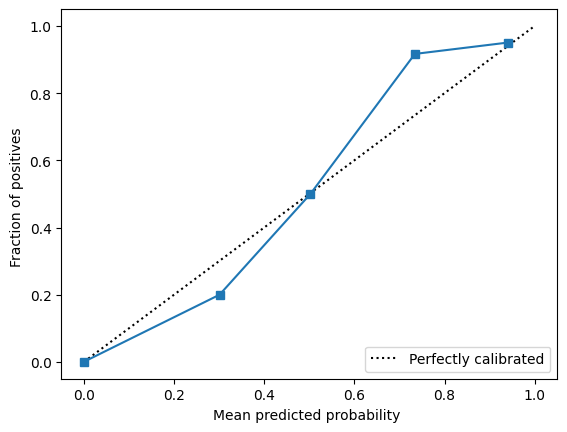

In [15]:
from sklearn.calibration import calibration_curve, CalibrationDisplay

# Get probabilities from model 
model_probs = model.predict_proba(X_test)[:, 1]

# Plot calibration curve 
prob_true, prob_pred = calibration_curve(y_test, model_probs, n_bins=5)
disp = CalibrationDisplay(prob_true, prob_pred, model_probs)
disp.plot();

Let's also train a few more models so we can compare them:

In [16]:
#| echo: false
nb = GaussianNB()
nb.fit(X_train, y_train)

lgbm = LGBMClassifier(verbose = -1)
lgbm.fit(X_train, y_train)

lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

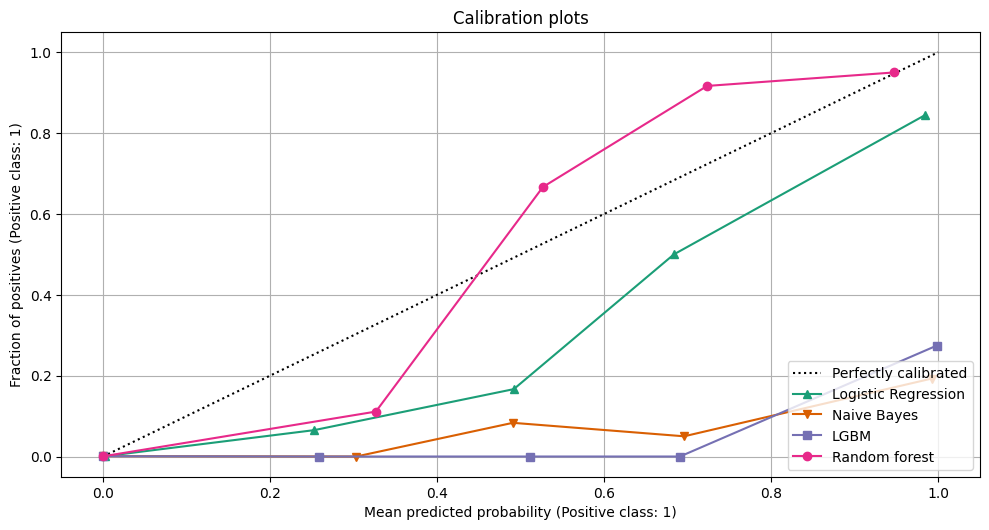

In [17]:
#| echo: false

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
# code from https://scikit-learn.org/stable/auto_examples/calibration/plot_compare_calibration.html#sphx-glr-auto-examples-calibration-plot-compare-calibration-py

# Create classifiers
clf_list = [
    (lr, "Logistic Regression"),
    (nb, "Naive Bayes"),
    (lgbm, "LGBM"),
    (model, "Random forest"),
]

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
markers = ["^", "v", "s", "o"]
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=5,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
        marker=markers[i],
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")


plt.tight_layout()
plt.show()


TO DO 
- add Brier score loss

#### CalibratedClassifierCV
There is more than one way to calibrate probabilities. The simplest one is to apply a logistic regression model to transform probabilities. 

Scikit-learn provides a module for calibrating probabilities with the `CalibratedClassifierCV` class. This method uses a cross-validation to fit the model in a training set and then calibrate the probabilities in a test set, and then the process is repeated over **k** times. 


In [18]:
from sklearn.calibration import CalibratedClassifierCV

clf_list = [
    (lr, "Logistic Regression"),
    (nb, "Naive Bayes"),
    (lgbm, "LGBM"),
    (model, "Random forest"),
]

calibrated_clfs = {}

for base_clf, clf_name in clf_list: 
    calibrated_clf = CalibratedClassifierCV(base_clf, cv=5)
    calibrated_clf.fit(X_train, y_train)
    calibrated_clfs[clf_name] = calibrated_clf

TO DO 

fazer gráfico comparando antes e depois 

## Cost classification model

Now that we have our probabilities calibrated, we can return to the original problem: let's write a code that classifies a transaction as a fraud or not taking into account the costs and profits involved with each prediction 

In [19]:
df_test_models_calib = X_test.assign(
    probs_lgbm = calibrated_clfs['LGBM'].predict_proba(X_test)[:, 1], 
    probs_nb = calibrated_clfs['Naive Bayes'].predict_proba(X_test)[:, 1], 
    probs_rf = calibrated_clfs['Random forest'].predict_proba(X_test)[:, 1], 
    probs_lr = calibrated_clfs['Logistic Regression'].predict_proba(X_test)[:, 1],
    y_true = y_test
)

In [20]:
def classify_sample(example, y_true): 
    if example == 1 and y_true == 1: return 'tp'
    elif example == 1 and y_true == 0: return 'fp'
    elif example == 0 and y_true == 0: return 'tn'
    elif example == 0 and y_true == 1: return 'fn'

def calculate_matrix_revenue(cfmatrix_class, amount): 
    if cfmatrix_class == 'tp': return  0 
    elif cfmatrix_class == 'fp': return -(amount * 0.1)
    elif cfmatrix_class == 'fn': return -amount 
    elif cfmatrix_class == 'tn': return (amount * 0.1) 

In [21]:
revenues_calibrated = {}

for p in ['probs_lgbm', 'probs_nb', 'probs_rf', 'probs_lr']:
    expected_rev_1, expected_rev_0 = get_example_value_dependent(df_test_models_calib[p], df_test_models_calib['Amount'])

    # Calculates prediction if expected_rev_1 > expected_rev_0
    df_rev = df_test_models_calib.assign(
        expected_rev_1 = expected_rev_1,
        expected_rev_0 = expected_rev_0,
        pred_fraud_cost_dep = lambda d: d.apply(lambda x: 1 if x['expected_rev_1'] > x['expected_rev_0'] else 0, axis = 1),
        cfmatrix_class = lambda d: d.apply(lambda x: classify_sample(x['pred_fraud_cost_dep'], x['y_true']),  axis = 1), 
        expected_revenue = lambda d: d.apply(lambda x: calculate_matrix_revenue(x['cfmatrix_class'], x['Amount']),  axis = 1)
    )

    revenues_calibrated[p] = round(df_rev.expected_revenue.sum(), 2)
    print(f'\n {p} expected revenue: ', round(df_rev.expected_revenue.sum(), 2))



 probs_lgbm expected revenue:  430881.25

 probs_nb expected revenue:  395791.99

 probs_rf expected revenue:  434517.69

 probs_lr expected revenue:  431157.77


Let's also take a look at how different these predictions would be had we not calibrated our probabilities before: 

In [22]:
df_test_models_uncalib = X_test.assign(
    probs_lgbm = lgbm.predict_proba(X_test)[:, 1], 
    probs_nb = nb.predict_proba(X_test)[:, 1], 
    probs_rf = model.predict_proba(X_test)[:, 1], 
    probs_lr = lr.predict_proba(X_test)[:, 1],
    y_true = y_test
)

In [23]:
revenues = {}

for p in ['probs_lgbm', 'probs_nb', 'probs_rf', 'probs_lr']:
    expected_rev_1, expected_rev_0 = get_example_value_dependent(df_test_models_uncalib[p], df_test_models_uncalib['Amount'])

    # Calculates prediction if expected_rev_1 > expected_rev_0
    df_rev_uncalib = df_test_models_uncalib.assign(
        expected_rev_1 = expected_rev_1,
        expected_rev_0 = expected_rev_0,
        pred_fraud_cost_dep = lambda d: d.apply(lambda x: 1 if x['expected_rev_1'] > x['expected_rev_0'] else 0, axis = 1),
        cfmatrix_class = lambda d: d.apply(lambda x: classify_sample(x['pred_fraud_cost_dep'], x['y_true']),  axis = 1), 
        expected_revenue = lambda d: d.apply(lambda x: calculate_matrix_revenue(x['cfmatrix_class'], x['Amount']),  axis = 1)
    )

    revenues[p] = round(df_rev_uncalib.expected_revenue.sum(), 2)
    print(f'\n {p} expected revenue: ', round(df_rev_uncalib.expected_revenue.sum(), 2))


 probs_lgbm expected revenue:  423811.72

 probs_nb expected revenue:  382894.53

 probs_rf expected revenue:  434370.52

 probs_lr expected revenue:  430939.14


In [24]:
compare_revs = pd.concat([pd.DataFrame(revenues_calibrated, index = ['revenues_calibrated']).T, 
                        pd.DataFrame(revenues, index = ['revenues_not_calibrated']).T], axis = 1
                    ).assign(
                        revenue_diff = lambda d: d['revenues_calibrated'] - d['revenues_not_calibrated']
                    )

compare_revs

,revenues_calibrated,revenues_not_calibrated,revenue_diff
probs_lgbm,430881.25,423811.72,7069.53
probs_nb,395791.99,382894.53,12897.46
probs_rf,434517.69,434370.52,147.17
probs_lr,431157.77,430939.14,218.63


In [25]:
best_model = compare_revs.revenues_calibrated.idxmax()

print(f'Best model probabilities are {best_model} with a total revenue of {compare_revs.loc[best_model, "revenues_calibrated"]}')

Best model probabilities are probs_rf with a total revenue of 434517.69
